In [1]:
import pandas as pd
import numpy as np
np.random.seed(7) #para obtener los mismos resultados cada vez que se ejecuta el codigo

from tqdm import tqdm_notebook
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

import os

import warnings
warnings.filterwarnings("ignore")

import datetime
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

from datetime import date, timedelta

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM
from sklearn.preprocessing import MinMaxScaler

In [2]:
delta = e_date - i_date # as timedelta

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

In [5]:
twt_ods = read_OD_fn('TWT')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [6]:
lista_twt = []

for date in tqdm_notebook(target_days):
    lista_twt.append(twt_ods[date].loc['total','total'])
    
del twt_ods
    
lista_ine = []

for date in tqdm_notebook(target_days):
    lista_ine.append(ine_ods[date].loc['total','total'])
    
del ine_ods

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [7]:
df_twt = pd.DataFrame (lista_twt, columns = ['Viajes'], index= target_days)
df_ine = pd.DataFrame (lista_ine, columns = ['Viajes'], index= target_days)

In [8]:
df_twt.head()

,Viajes
2020-04-01,2375
2020-04-02,2450
2020-04-03,2503
2020-04-04,554
2020-04-05,1319


# Visualización de datos

In [9]:
print(df_twt.index.min())
print(df_ine.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [10]:
print(len(df_twt['2020']))

81


In [11]:
print(len(df_ine['2020']))

81


In [12]:
df_twt.describe()

,Viajes
count,81.000000
mean,2943.000000
std,887.069149
min,0.000000
25%,2363.000000
50%,2904.000000
75%,3629.000000
max,4738.000000


In [13]:
df_ine.describe()

,Viajes
count,8.100000e+01
mean,3.438222e+06
std,1.174931e+06
min,1.535886e+06
25%,2.488436e+06
50%,3.396402e+06
75%,4.445190e+06
max,5.519725e+06


In [14]:
meses = df_twt.resample('M').mean()
meses

,Viajes
2020-04-30,2157.500000
2020-05-31,3128.193548
2020-06-30,3834.200000


In [15]:
meses = df_ine.resample('M').mean()
meses

,Viajes
2020-04-30,2.356878e+06
2020-05-31,3.590722e+06
2020-06-30,4.823862e+06


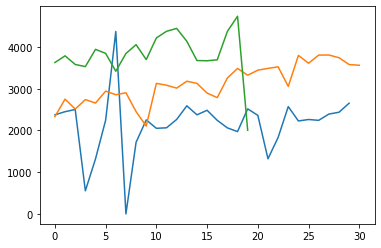

In [16]:
abril = df_twt['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_twt['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_twt['2020-06-01':'2020-06-20']
plt.plot(junio.values)

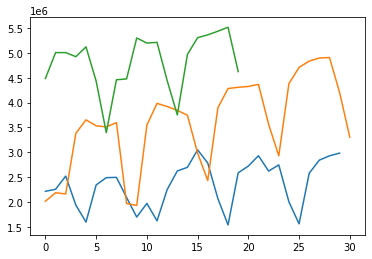

In [17]:
abril = df_ine['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_ine['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_ine['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [18]:
dataset_twt = df_twt.values
dataset_twt = dataset_twt.astype('float32')

dataset_ine = df_ine.values
dataset_ine = dataset_ine.astype('float32')

In [19]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_twt = scaler.fit_transform(dataset_twt)
dataset_ine = scaler.fit_transform(dataset_ine)

# Dividimos los datos en sets de entrenamiento y validacion

In [20]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train_twt = dataset_twt[:n_train_days, :]
test_twt = dataset_twt[n_train_days:, :]

train_ine = dataset_ine[:n_train_days, :]
test_ine = dataset_ine[n_train_days:, :]

print(len(train_twt), len(test_twt))

60 21


In [21]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset1, dataset2, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset2)-look_back):
    a = []
    for x in range(look_back):
        a.append(dataset2[i+x])  
        a.append(dataset1[i+x])
    a = np.array(a)
    a = np.reshape(a, (7, 1, 2))
    dataX.append(a)
    dataY.append(dataset2[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [22]:
# dividimos en entradas y salidas
look_back = 7
trainX, trainY = create_dataset(train_twt, train_ine, look_back)
testX, testY = create_dataset(test_twt, test_ine, look_back)

print(len(trainX), len(testY))

53 14


In [23]:
print(trainX)

[[[[0.16999608 0.50126636]]

  [[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]]


 [[[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]]


 [[[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]]


 [[[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]]


 [[[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]

  [[0.

In [24]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], testX.shape[1], 2))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 2))

In [25]:
print(trainX)

[[[0.16999608 0.50126636]
  [0.18028718 0.5170958 ]
  [0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]]

 [[0.18028718 0.5170958 ]
  [0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]]

 [[0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]]

 [[0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]
  [0.03971621 0.4755171 ]]

 [[0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]
  [0.03971621 0.4755171 ]
  [0.10891479 0.43309414]]

 [[0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  

In [26]:
print(trainY)

[0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
 0.27293295 0.2914425  0.37988257 0.313093   0.13297123 0.
 0.26343662 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752
 0.00537395 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008
 0.16276813 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993
 0.51747626 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086
 0.5796803  0.5546241  0.3633111  0.22455525 0.59261984 0.689921
 0.6962447  0.7003162  0.71110225 0.50901634 0.34968656 0.7144731
 0.7966052  0.82881963 0.8441757  0.8469062  0.6693162 ]


# Creamos la red neuronal

In [27]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,2), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,2), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,2)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [28]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,541
Trainable params: 76,541
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0116 - val_loss: 0.0110
Epoch 124/200
53/53 - 0s - loss: 0.0088 - val_loss: 0.0101
Epoch 125/200
53/53 - 0s - loss: 0.0093 - val_loss: 0.0086
Epoch 126/200
53/53 - 0s - loss: 0.0102 - val_loss: 0.0123
Epoch 127/200
53/53 - 0s - loss: 0.0088 - val_loss: 0.0131
Epoch 128/200
53/53 - 0s - loss: 0.0107 - val_loss: 0.0194
Epoch 129/200
53/53 - 0s - loss: 0.0121 - val_loss: 0.0128
Epoch 130/200
53/53 - 0s - loss: 0.0090 - val_loss: 0.0131
Epoch 131/200
53/53 - 0s - loss: 0.0095 - val_loss: 0.0100
Epoch 132/200
53/53 - 0s - loss: 0.0078 - val_loss: 0.0067
Epoch 133/200
53/53 - 0s - loss: 0.0113 - val_loss: 0.0168
Epoch 134/200
53/53 - 0s - loss: 0.0115 - val_loss: 0.0121
Epoch 135/200
53/53 - 0s - loss: 0.0118 - val_loss: 0.0152
Epoch 136/200
53/53 - 0s - loss: 0.0103 - val_loss: 0.0106
Epoch 137/200
53/53 - 0s - loss: 0.0095 - val_loss: 0.0104
Epoch 138/200
53/53 - 0s - loss: 0.0093 - val_loss: 0.0157
Epoch 139/200
53/53 - 0s - loss: 0.0111 - val_loss: 0.01

# Visualizamos resultados

In [29]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    ## actual train and test values

    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [30]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [31]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 236504.49 MAE
Resultado del entrenamiento: 99350258802.10 MSE
Resultado del entrenamiento: 315198.76 RMSE
Resultado del entrenamiento: 10.23 CVRMSE
Resultado del entrenamiento: 9.73 MAPE 

Resultado del test: 365546.60 MAE
Resultado del test: 181788731740.09 MSE
Resultado del test: 426366.90 RMSE
Resultado del test: 8.84 CVRMSE
Resultado del test: 8.22 MAPE


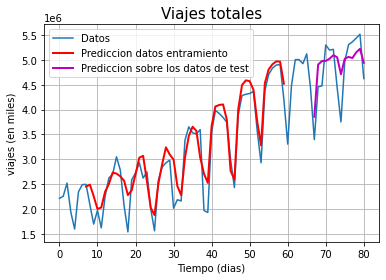

In [32]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset_ine)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset_ine)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset_ine), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_ine))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

In [33]:
results=testPredict
print(len(results))

14


In [34]:
test = testY_scalerInverse[0]

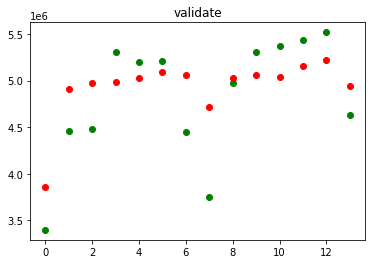

In [35]:
plt.scatter(range(len(test)),test,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

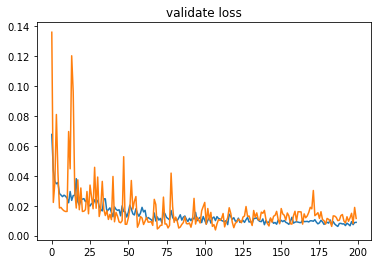

In [36]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

In [37]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

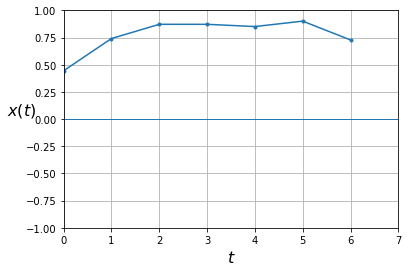

In [38]:
n_steps = 6 #preguntar
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [39]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,3857115.25
2020-06-08,4908385.50
2020-06-09,4978387.00
2020-06-10,4982196.00
2020-06-11,5026487.00
2020-06-12,5097043.50
2020-06-13,5056018.00
2020-06-14,4712991.00
2020-06-15,5025953.00
2020-06-16,5063295.50


In [40]:
datosReales = df_ine['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,3396402,3857115.25
2020-06-08,4461143,4908385.50
2020-06-09,4478072,4978387.00
2020-06-10,5303428,4982196.00
2020-06-11,5200931,5026487.00
2020-06-12,5215302,5097043.50
2020-06-13,4445190,5056018.00
2020-06-14,3753016,4712991.00
2020-06-15,4973188,5025953.00
2020-06-16,5308885,5063295.50


In [41]:
compara.to_excel('Resultados INE - TWT.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [42]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error
Dias_twt = df_twt['2020-5-01':'2020-5-7']
Dias_ine = df_ine['2020-5-01':'2020-5-7']

# Preparamos los datos para el test

In [43]:
# cargamos el dataframe en la variable dataset
dataset_twt = Dias_twt.values
dataset_ine = Dias_ine.values

# convertimos los enteros en floats
dataset_twt = dataset_twt.astype('float32')
dataset_ine = dataset_ine.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_twt = scaler.fit_transform(dataset_twt)
dataset_ine = scaler.fit_transform(dataset_ine)

In [44]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset2(dataset1, dataset2):
  dataX = []
  for x in range(len(dataset2)):
    dataX.append(dataset2[x])  
    dataX.append(dataset1[x])
  dataX = np.array(dataX)
  dataX = np.reshape(dataX, (7, 1, 2))
  return np.array(dataX)

In [45]:
# usamos la funcion definida previamente para crear el dataset
testX = create_dataset2(dataset_twt, dataset_ine)

In [46]:
#remodelamos los datos
testX = np.reshape(testX, (1, 7, 2))

In [47]:
#definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[0]-1):
        x_test[i] = x_test[i+1]
    x_test[x_test.shape[0]-1]=nuevoValor
    return x_test

# Realizamos la prediccion 

In [48]:
#tomamos los siguientes 7 dias de twitter para unirlos a los resultados que reemplazaran a los valores del ine
parcial_twt_dias = df_twt['2020-5-08':'2020-5-14']
parcial_twt = parcial_twt_dias.values
parcial_twt = parcial_twt.astype('float32')
parcial_twt = scaler.fit_transform(parcial_twt)

print(parcial_twt)

[[0.74256504]
 [0.3224908 ]
 [0.        ]
 [0.95074356]
 [0.91078055]
 [0.84572494]
 [0.9999999 ]]


In [49]:
#estos serian los resultados reales del ine
parcial_ine_dias = df_ine['2020-5-08':'2020-5-14']
parcial_ine = parcial_ine_dias.values
parcial_ine = parcial_ine.astype('float32')
parcial_ine = scaler.fit_transform(parcial_ine)

print(parcial_ine)

[[0.81142676]
 [0.0189693 ]
 [0.        ]
 [0.78619885]
 [1.        ]
 [0.9692731 ]
 [0.9318799 ]]


In [50]:
results = []
for i in range(7):
    parcial=model.predict(testX)
    parcial_ine=parcial[0]
    results.append(parcial_ine[0])
    dataset_ine=agregarNuevoValor(dataset_ine,parcial_ine[0])
    dataset_twt=agregarNuevoValor(dataset_twt,parcial_twt[i])
    testX = create_dataset2(dataset_twt, dataset_ine)
    testX = np.reshape(testX, (1, 7, 2))
    print(testX)

[[[ 0.10419428  0.685246  ]
  [ 0.08904922  0.29672146]
  [ 0.83475256  0.66721296]
  [ 1.          0.5311475 ]
  [ 0.9270716   1.        ]
  [ 0.9134474   0.85737705]
  [-0.05886151  0.74256504]]]
[[[ 0.08904922  0.29672146]
  [ 0.83475256  0.66721296]
  [ 1.          0.5311475 ]
  [ 0.9270716   1.        ]
  [ 0.9134474   0.85737705]
  [-0.05886151  0.74256504]
  [ 0.02578016  0.3224908 ]]]
[[[ 0.83475256  0.66721296]
  [ 1.          0.5311475 ]
  [ 0.9270716   1.        ]
  [ 0.9134474   0.85737705]
  [-0.05886151  0.74256504]
  [ 0.02578016  0.3224908 ]
  [ 0.6691607   0.        ]]]
[[[ 1.          0.5311475 ]
  [ 0.9270716   1.        ]
  [ 0.9134474   0.85737705]
  [-0.05886151  0.74256504]
  [ 0.02578016  0.3224908 ]
  [ 0.6691607   0.        ]
  [ 0.848298    0.95074356]]]
[[[ 0.9270716   1.        ]
  [ 0.9134474   0.85737705]
  [-0.05886151  0.74256504]
  [ 0.02578016  0.3224908 ]
  [ 0.6691607   0.        ]
  [ 0.848298    0.95074356]
  [ 0.8845929   0.91078055]]]
[[[ 0.9134

In [51]:
results = np.reshape(results, (7, 1))
print(results)

[[-0.05886151]
 [ 0.02578016]
 [ 0.6691607 ]
 [ 0.848298  ]
 [ 0.8845929 ]
 [ 0.82425207]
 [ 0.6484672 ]]


# Re-Convertimos los resultados

In [52]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[1806964],
       [1981099],
       [3304741],
       [3673284],
       [3747954],
       [3623814],
       [3262168]])

# Visualizamos el pronostico

<AxesSubplot:>

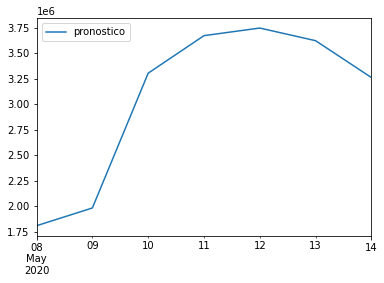

In [53]:
e_date = datetime.datetime.strptime('2020-05-14', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-08', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [54]:
datosReales = df_ine['2020-5-08':'2020-5-14']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']
compara

,real,prediccion
2020-05-08,3597428,1806964
2020-05-09,1967087,1981099
2020-05-10,1928061,3304741
2020-05-11,3545526,3673284
2020-05-12,3985384,3747954
2020-05-13,3922169,3623814
2020-05-14,3845239,3262168


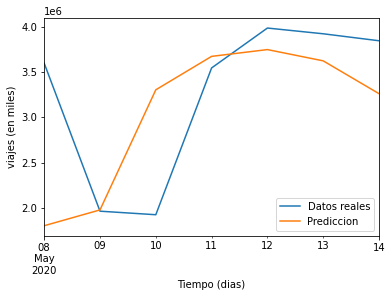

In [55]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [56]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 632538.57 MAE
Resultado del test: 800412586052.86 MSE
Resultado del test: 894657.80 RMSE
Resultado del test: 29.26 CVRMSE
Resultado del test: 25.34 MAPE
